# Analyze antibody escape over time

## Import Python modules

In [1]:
import os
import glob
import pandas as pd

## Read in data that predicts how much each virus has escaped each antibody

In [12]:
! tree data

data
└── ncov_escape_scores
    ├── C68.3-BA1_escape_score_variant_escape_prediction.csv
    ├── C68.3-BA2_escape_score_variant_escape_prediction.csv
    ├── C68.59_polclonal_escape_prediction.csv
    ├── C68.61-BA2_escape_score_variant_escape_prediction.csv
    ├── CC67.105_polclonal_escape_prediction.csv
    ├── CC9.104_polclonal_escape_prediction.csv
    ├── LCB1_v2.2_stringent-WH1_escape_score_variant_escape_prediction.csv
    ├── LY-CoV1404-BA1_escape_score_variant_escape_prediction.csv
    ├── metadata_with_index.tsv
    └── NTD_5-7_polclonal_escape_prediction.csv

1 directory, 10 files


In [5]:
! head -n 1 data/ncov_escape_scores/C68.3-BA1_escape_score_variant_escape_prediction.csv

strain,seq,aa_substitutions,additive


In [15]:
! head -n 1 data/ncov_escape_scores/metadata_with_index.tsv

strain	virus	gisaid_epi_isl	genbank_accession	genbank_accession_rev	sra_accession	date	region	country	division	location	region_exposure	country_exposure	division_exposure	segment	length	host	age	sex	Nextstrain_clade	pango_lineage	GISAID_clade	originating_lab	submitting_lab	authors	url	title	paper_url	date_submitted	date_updated	sampling_strategy	database	clade_nextstrain	clade_who	Nextclade_pango	immune_escape	ace2_binding	missing_data	divergence	nonACGTN	coverage	rare_mutations	reversion_mutations	potential_contaminants	QC_missing_data	QC_mixed_sites	QC_rare_mutations	QC_snp_clusters	QC_frame_shifts	QC_stop_codons	QC_overall_score	QC_overall_status	frame_shifts	deletions	insertions	substitutions	aaSubstitutions	clock_deviation	global	custom	_A	_C	_G	_T	_N	_other_IUPAC	_-	_?	_invalid_nucleotides	_length


In [19]:
metadata = pd.read_csv("data/ncov_escape_scores/metadata_with_index.tsv", sep="\t", index_col=0)
metadata["Nextstrain_clade"].unique()

array(['19A', '22E (Omicron)', '21K (Omicron)', '20B', '22F (Omicron)',
       '22D (Omicron)', '20E (EU1)', '22B (Omicron)', '23A (Omicron)',
       '20J (Gamma, V3)', '20I (Alpha, V1)', '20A', '20G', '20C',
       '22A (Omicron)', 'recombinant', '21J (Delta)', '23B (Omicron)',
       '21L (Omicron)', '19B', '21I (Delta)', '22C (Omicron)',
       '21C (Epsilon)', '21D (Eta)', '20D', '21G (Lambda)', '20F',
       '21A (Delta)', '?', '21E (Theta)', '21F (Iota)', '20H (Beta, V2)',
       '21H (Mu)', '21M (Omicron)', '21B (Kappa)'], dtype=object)

In [29]:
# Make a list of input files, with one file per antibody
ab_escape_files = glob.glob('data/ncov_escape_scores/*.csv')

# Read in data from each file and store data in a dataframe
antibodies = []
for (i, f) in enumerate(ab_escape_files):
    df = pd.read_csv(f)
    ab = os.path.basename(f).replace('_polclonal_escape_prediction.csv', '').replace('_escape_score_variant_escape_prediction.csv', '')
    if 'additive' in df.columns.values:
        escape_score_col = f'{ab}_escape_score'
        df.rename(columns={'additive' : escape_score_col}, inplace=True)
    else:
        escape_score_col = f'{ab}_IC90_log_fold_change'

    if i == 0:
        escape_df = df[['strain', 'aa_substitutions', escape_score_col]]
    else:
        escape_df = escape_df.merge(
            df[['strain', escape_score_col]],
            on='strain'
        )
    antibodies.append(escape_score_col)

# Add a column giving the date of each strain
metadata_df = pd.read_csv(
    'data/ncov_escape_scores/metadata_with_index.tsv',
    sep='\t', on_bad_lines='skip'
    )

escape_df = escape_df.merge(
    metadata_df[['strain', 'date', 'Nextstrain_clade']], on='strain'
)
escape_df['date'] = pd.to_datetime(escape_df['date'])
escape_df['time'] = (escape_df['date'] - escape_df['date'].min()).dt.days / 365
escape_df.head()

,strain,aa_substitutions,C68.61-BA2_escape_score,LCB1_v2.2_stringent-WH1_escape_score,CC67.105_IC90_log_fold_change,NTD_5-7_IC90_log_fold_change,CC9.104_IC90_log_fold_change,C68.3-BA1_escape_score,LY-CoV1404-BA1_escape_score,C68.3-BA2_escape_score,C68.59_IC90_log_fold_change,date,Nextstrain_clade,time
0,Wuhan-Hu-1/2019,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647,2019-12-26,19A,0.000000
1,NPL/61-TW/2020,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647,2020-01-13,19A,0.049315
2,Mesocricetusauratus/HKG/13_P2/2020,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647,2020-05-15,19A,0.386301
3,CHN/Hefei-362/2020,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647,2020-02-09,19A,0.123288
4,USA/WI-CDC-03041142-001/2020,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647,2020-01-31,19A,0.098630


Just re-arranging the columns a bit for readability, and keeping track of the feature columns for downstream analysis

In [64]:
strain_feature_cols = ['strain', 'time', 'date', 'Nextstrain_clade', 'aa_substitutions']
escape_cols = [c for c in escape_df.columns if c not in first_cols]
escape_df = escape_df.loc[:, strain_feature_cols + escape_cols]
escape_df.head()

,strain,time,date,Nextstrain_clade,aa_substitutions,C68.61-BA2_escape_score,LCB1_v2.2_stringent-WH1_escape_score,CC67.105_IC90_log_fold_change,NTD_5-7_IC90_log_fold_change,CC9.104_IC90_log_fold_change,C68.3-BA1_escape_score,LY-CoV1404-BA1_escape_score,C68.3-BA2_escape_score,C68.59_IC90_log_fold_change
0,Wuhan-Hu-1/2019,0.000000,2019-12-26,19A,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647
1,NPL/61-TW/2020,0.049315,2020-01-13,19A,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647
2,Mesocricetusauratus/HKG/13_P2/2020,0.386301,2020-05-15,19A,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647
3,CHN/Hefei-362/2020,0.123288,2020-02-09,19A,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647
4,USA/WI-CDC-03041142-001/2020,0.098630,2020-01-31,19A,D339G F371S P373S F375S A376T N405D S408R N417...,0.103019,0.0,0.683449,-2.203219,1.203864,0.11961,0.137017,0.072882,1.010647


## Analyze escape over time

Define our sliding windows

In [65]:
# Define parameters for windows
start_time = 0
end_time = 3
window_width = 0.1
window_step_size = 0.05

# To start, we set the left side of our window at a value
# of zero
left_side_of_window = 0

# We're going to define all windows one at a time
# based on the step size and width
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    
    # Append the window value to the list
    list_of_left_sides_of_windows.append(left_side_of_window)
    #print(left_side_of_window, left_side_of_window+window_width)

    # Slide the window to the right by one step
    left_side_of_window = left_side_of_window + window_step_size

For each window, get the viruses in that window and then compute the average escape for a given antibody.

In [66]:
# Make a dictionary for keeping track of averages in each window

# Iterate over each window and record data
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Get data for viruses within a given window
    data = escape_df[
        escape_df['time'].between(left_side_of_window, right_side_of_window)
    ]

    # Loop over antibodies, and compute the average amount that
    # viruses have escaped each antibody
    for antibody in antibodies:
        print(left_side_of_window, antibody, data[antibody].mean())

0 C68.61-BA2_escape_score 0.10301899999999999
0 LCB1_v2.2_stringent-WH1_escape_score 0.0
0 CC67.105_IC90_log_fold_change 0.6834492261711471
0 NTD_5-7_IC90_log_fold_change -2.2032193361433863
0 CC9.104_IC90_log_fold_change 1.2038643038358143
0 C68.3-BA1_escape_score 0.11961
0 LY-CoV1404-BA1_escape_score 0.13701699999999992
0 C68.3-BA2_escape_score 0.072882
0 C68.59_IC90_log_fold_change 1.0106466888370578
0.05 C68.61-BA2_escape_score 0.10301899999999999
0.05 LCB1_v2.2_stringent-WH1_escape_score 0.0
0.05 CC67.105_IC90_log_fold_change 0.6907253291064185
0.05 NTD_5-7_IC90_log_fold_change -2.2027616565739967
0.05 CC9.104_IC90_log_fold_change 1.229126879775448
0.05 C68.3-BA1_escape_score 0.11961
0.05 LY-CoV1404-BA1_escape_score 0.13701699999999992
0.05 C68.3-BA2_escape_score 0.072882
0.05 C68.59_IC90_log_fold_change 0.9910633484300049
0.1 C68.61-BA2_escape_score 0.103019
0.1 LCB1_v2.2_stringent-WH1_escape_score 0.0
0.1 CC67.105_IC90_log_fold_change 0.6513494352774729
0.1 NTD_5-7_IC90_log_fold

Here's the next task:
* the above cell of code, has a for loop that loops over windows, and in each window, it loop over antibodies
* for each antibody in each window, we'd like to record the mean escape, which is currently being printed above. We'd like to store these means in a dictionary or dataframe
* finally, we'd like to plot these means, making the kinds of plots that are on the board
* we should analyze the antibodies in two groups
    * one group is the group with the suffix `_IC90_log_fold_change`
    * the other group is the group with the suffix `_escape_score`

In [78]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)
# Iterate over each window and record data
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Get data for viruses within a given window
    data = escape_df[
        escape_df['time'].between(left_side_of_window, right_side_of_window)
    ]
    
    # Loop over antibodies, and compute the average amount that
    # viruses have escaped each antibody
    for antibody in antibodies:
        
        window_data["left_side"].append(left_side_of_window)
        window_data["Ab"].append(antibody)
        average_of_all_samples_in_window = data[antibody].mean()
        window_data["mean_escape"].append(average_of_all_samples_in_window)
            
window_data = pd.DataFrame(window_data)
print(window_data.info())
window_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   left_side    549 non-null    float64
 1   Ab           549 non-null    object 
 2   mean_escape  549 non-null    float64
dtypes: float64(2), object(1)
memory usage: 13.0+ KB
None


,left_side,Ab,mean_escape
0,0.0,C68.61-BA2_escape_score,0.103019
1,0.0,LCB1_v2.2_stringent-WH1_escape_score,0.000000
2,0.0,CC67.105_IC90_log_fold_change,0.683449
3,0.0,NTD_5-7_IC90_log_fold_change,-2.203219
4,0.0,CC9.104_IC90_log_fold_change,1.203864


`.query()` can be very powerful for getting subsets of data

In [106]:
window_data.query(f"Ab.str.contains('log_fold')")

,left_side,Ab,mean_escape
2,0.00,CC67.105_IC90_log_fold_change,0.683449
3,0.00,NTD_5-7_IC90_log_fold_change,-2.203219
4,0.00,CC9.104_IC90_log_fold_change,1.203864
8,0.00,C68.59_IC90_log_fold_change,1.010647
11,0.05,CC67.105_IC90_log_fold_change,0.690725
...,...,...,...
539,2.95,C68.59_IC90_log_fold_change,0.449893
542,3.00,CC67.105_IC90_log_fold_change,0.645982
543,3.00,NTD_5-7_IC90_log_fold_change,-1.270718
544,3.00,CC9.104_IC90_log_fold_change,0.224109


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

makes figures look nicer

In [96]:
%matplotlib inline 

pro tip - anytime you see the term `axes` in matplotlib, you're referring to a "singular subplot" within a greater "figure". 

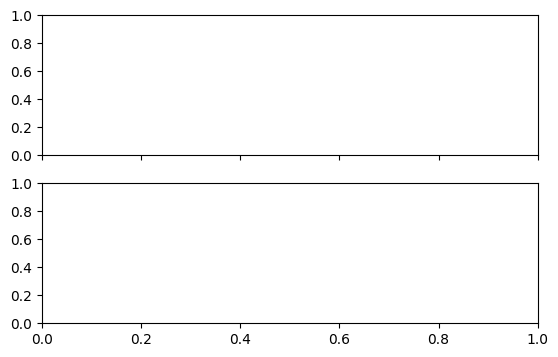

In [107]:
fig, ax = plt.subplots(2,1, figsize=(6.4,4), sharex=True)

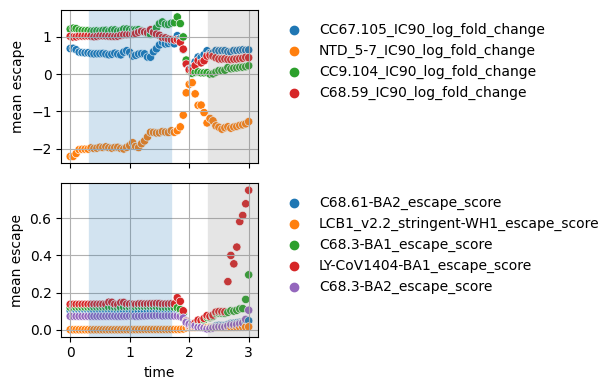

In [108]:
fig, ax = plt.subplots(2,1, figsize=(6.4,4), sharex=True)
ax[0].axvline(1, alpha=0.2, linewidth=60)
ax[1].axvline(1, alpha=0.2, linewidth=60)

ax[0].axvline(3, alpha=0.2, linewidth=60, c="grey")
ax[1].axvline(3, alpha=0.2, linewidth=60, c="grey")

for subplot_index, group in enumerate(["log_fold", "escape_score"]):
    
    iteration_axes = ax[subplot_index]
    
    sns.scatterplot(
        data=window_data.query(f"Ab.str.contains('{group}')"), 
        x="left_side", 
        y="mean_escape", 
        hue="Ab", 
        ax=iteration_axes
    )
    
    iteration_axes.grid()
    iteration_axes.set_ylabel(f"mean escape")
    
ax[1].set_xlabel(f"time")    
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', frameon=False)
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', frameon=False)


plt.tight_layout()
plt.show()

Next task. Give some explanation about what's going on at 2? Earlier in the notebook, hugh computes the time from the dates. Figure out what those dates are (and maybe replace the xaxis with those), and cross reference it with what going on at that time point in the nextstrain tree. Maybe that's where the sliding window starts looking at (computing averages from) the large amount of "extant" or "leaf nodes" in the tree. I could definitely be wrong though. Either way, there's clearly a difference between time `[0-2]` and `[2-3]` and I'm curious.

If you think it's helpful, Omar and I put together some starter code that will allow you to play with clade level information at each interation in the window. this is the same code as before, but shows that you can access clades here.

In [109]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)
# Iterate over each window and record data
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Get data for viruses within a given window
    data = escape_df[
        escape_df['time'].between(left_side_of_window, right_side_of_window)
    ]
    
    #####
    # now, the variable `data` has a feature, nextstrain clade that you can split by.
    # for example
    unique_clades = data["Nextstrain_clade"].unique()
    print(f"left: {left_side_of_window}\n{unique_clades}\n\n")
    #####
    
    
    # Loop over antibodies, and compute the average amount that
    # viruses have escaped each antibody
    for antibody in antibodies:

        window_data["left_side"].append(left_side_of_window)
        window_data["Ab"].append(antibody)
        average_of_all_samples_in_window = data[antibody].mean()
        window_data["mean_escape"].append(average_of_all_samples_in_window)
            
# pd.DataFrame(window_data)

left: 0
['19A' '19B']


left: 0.05
['19A' '19B']


left: 0.1
['19A' '19B' '20A' '20C']


left: 0.15000000000000002
['19A' '19B' '20A' '20C' '20B' '20D']


left: 0.2
['19A' '19B' '20A' '20C' '20B' '20D']


left: 0.25
['19A' '19B' '20A' '20C' '20B']


left: 0.3
['19A' '19B' '20A' '20C' '20B' '20D']


left: 0.35
['19A' '19B' '20A' '20C' '20B' '20D']


left: 0.39999999999999997
['19B' '20A' '20C' '20B' '20F']


left: 0.44999999999999996
['19B' '20A' '20C' '20G' '20B' '20D' '20F']


left: 0.49999999999999994
['19B' '20A' '20C' '20G' '20B' '20D' '20F']


left: 0.5499999999999999
['19B' '20A' '20E (EU1)' '20C' '20G' '20B' '20D' '20F']


left: 0.6
['19B' '20A' '20E (EU1)' '20G' '20C' '20B' '20D']


left: 0.65
['20A' '20C' '20G' '20B' '20D']


left: 0.7000000000000001
['19A' '19B' '20A' '20E (EU1)' '20C' '20G' '20B' '20D']


left: 0.7500000000000001
['19A' '19B' '20A' '20E (EU1)' '20G' '20C' '20B' '20D']


left: 0.8000000000000002
['20A' '20E (EU1)' '20G' '20C' '20B' '20D' '20I (Alpha, V1)']


